In [1]:
using Pkg
Pkg.activate("./Packages/Project.toml");

  Activating project at `c:\Users\HP\OneDrive\Documentos\julia\Heisenberg-Model-3D\Packages`


In [2]:
import Pkg
Pkg.add("Plots")

    Updating registry at `C:\Users\HP\.julia\registries\General.toml`
   Resolving package versions...
  No Changes to `C:\Users\HP\OneDrive\Documentos\julia\Heisenberg-Model-3D\Packages\Project.toml`
  No Changes to `C:\Users\HP\OneDrive\Documentos\julia\Heisenberg-Model-3D\Packages\Manifest.toml`


In [4]:
using LinearAlgebra
using Statistics
using Random
using Printf
using Plots

In [5]:
function RandomSpin()
    """Creates a random unit vector"""
    θ = rand(0:1e-6:π)
    ϕ = rand(0:1e-6:2π)
    return [sin(θ)*cos(ϕ), sin(θ)*sin(ϕ), cos(θ)]
end

function AcceptanceProbability(Spin1, Spin2, n, βJ)
    """Computes the probability of adding Spin2 - neighbour of
    Spin1 - to the cluster. It uses the energy βJ and the vector 
    of reflection n"""
    return 1 - exp(min(0,-2βJ*transpose(Spin1)*n*transpose(Spin2)*n))
end

function ReflectSpin(S,n,state)
    """Reflectes the spin state[S] around the plane defined by the
    normal vector n"""
    state[S] -=  2(transpose(state[S])*n)*n
end

function GetNeighbours(x,L,L2,L3)
    """Gets the coordinates of the 6 neighbour spins of the one in index x. It uses 
    periodic boundery conditions in a 3D lattice of length L (area L2, volume L3). 
    The matriz it returns contains the neighbours as folows: 
    [Up-Down-Left-Right-Front-Back]"""
    return [L2*((x-1)÷L2)+(x-1-L+L2)%L2+1,
            L2*((x-1)÷L2)+(x-1+L)%L2+1,
            L*((x-1)÷L)+(x+L-2)%L+1,
            L*((x-1)÷L)+(x)%L+1,
            (x-L2+L3-1)%L3+1,
            (x+L2-1)%L3+1]
end

function Grow_Reflect(S, Cluster, n, βJ, L, L2, L3, state)
    """Checks every neighbour of spin state[S] and adds them to the Cluster given
    a certain probability (See to AcceptanceProbability). Finally, it reflects
    the spin around the normal vector n (Refair to ReflectSpin)"""
    #Checks neighbours
    for Sn in GetNeighbours(S,L,L2,L3)
        if Sn ∉ Cluster && rand(0:1e-15:1) < AcceptanceProbability(state[S],state[Sn],n,βJ)
            #Adds neighbour to Cluster
            push!(Cluster,Sn)
            #Checks neighbours of neighbour
            Grow_Reflect(Sn, Cluster, n, βJ, L, L2, L3, state)
        end
    end
    #Reflects the spin
    ReflectSpin(S,n, state)
end

function NewState(state, L, L2, L3, βJ)
    """Chooses a randon spin from the state with lattice sice L, and also a
    random normal vector. From there it builds the cluster using Wolff algorithm
    (See Grow_Reflect)"""
    n = RandomSpin()     #Initial random Normal Vector
    #n = [0,0,1]         #Just for testing
    S0 = rand(1:1:L3)    #Initial random Spin
    Cluster = [S0]       #Stores the indexes of the spins added to the cluster
    Grow_Reflect(S0, Cluster, n, βJ, L, L2, L3, state) #Builds cluster and flips states for new state
    #print("The Cluster contains:  ",Cluster,"\n") #Just for testing
end;

In [6]:
function RandomIsing()
    """Creates spins only in the z-axis (testing only)"""
    return [0, 0, rand(-1.:2:1.)]
end;

In [7]:
function magnetization(state)
    """Returns the magnetization as the norm of the sum of all spins in the grid"""
    return norm(sum(state))
end;

In [8]:
function suceptibility(state)
    """Returns the msuceptibiliti as the variance of magnetizacion"""
    return norm(sum(state*transpose(state))) - norm(sum(state))^2
end;

In [9]:
function Proceed(βJ, epochs, jumps, L)
    """Creates a sequence of states and gets the magnetization once every fixed number 
    of epochs (i.e. jumps); finally, it returns the simple mean of all values obtained 
    this way. This is done for a single value of βJ in a lattice of size L."""
    L2 = L*L   #Lattice Area
    L3 = L*L2  #Lattice Volume
    #state = [RandomIsing() for i in 1:L3] #Just for testing
    state = [RandomSpin() for i in 1:L3]   #The 3D lattice is store as a 1D-Array
    #Random.seed!(51)
    M = []
    S = []
    for jj in 1:epochs
        NewState(state, L, L2, L3, βJ)
        if jj%jumps == 0
            push!(M,magnetization(state))
            push!(S,magnetization(state*transpose(state)))
        end
    end
    suc = mean(M)^2- mean(S)
    return mean(M), suc
end;

In [16]:
Ms2 = [] #Stores magnetization for different tempetures
Ss2 = [] 
L = 10  #Lattice size
epochs = 80000   #Number of states generated
jumps = 1000     #Number of steps after which magnetization is calculated 
for kk in 1:30   #Loop over 30 different tempetures
    A, B = Proceed(.07*kk, epochs, jumps, L)
    print("βJ=")
    @printf("%.2f",0.07*kk)
    print("--->", B,"\n")
    push!(Ms2,A)
    push!(Ss2,B)
end

βJ=0.07--->-1.8011148128493914e-13
βJ=0.14--->2.6183499812759693e-13
βJ=0.21--->4.743760939618369e-13
βJ=0.28--->4.949152199174023e-13
βJ=0.35--->3.9115377603593513e-13
βJ=0.42--->8.668621376273222e-14
βJ=0.49--->-4.355626970209414e-13
βJ=0.56--->-6.430411758628907e-13
βJ=0.63--->-2.2851054382044824e-12
βJ=0.70--->1.0822986951097846e-11
βJ=0.77--->-4.729372449219227e-12
βJ=0.84--->-2.6921043172478677e-11
βJ=0.91--->-1.0913936421275139e-11
βJ=0.98--->7.057678885757923e-11
βJ=1.05--->-2.255546860396862e-11
βJ=1.12--->-7.494236342608929e-11
βJ=1.19--->2.9103830456733704e-11
βJ=1.26--->-1.746229827404022e-11
βJ=1.33--->7.275957614183426e-11
βJ=1.40--->6.257323548197746e-11
βJ=1.47--->5.3842086344957354e-11
βJ=1.54--->-6.693881005048751e-11
βJ=1.61--->5.820766091346741e-11
βJ=1.68--->-3.637978807091713e-11
βJ=1.75--->1.280568540096283e-10
βJ=1.82--->-4.3655745685100555e-11
βJ=1.89--->1.673470251262188e-10
βJ=1.96--->9.895302355289459e-11
βJ=2.03--->3.7834979593753816e-11
βJ=2.10--->-4.94765

In [15]:
Ms = [] #Stores magnetization for different tempetures
Ss = [] 
L = 10  #Lattice size
epochs = 80000   #Number of states generated
jumps = 1000     #Number of steps after which magnetization is calculated 
for kk in 1:30   #Loop over 30 different tempetures
    A, B = Proceed(.07*kk, epochs, jumps, L)
    print("βJ=")
    @printf("%.2f",0.07*kk)
    print("--->", B,"\n")
    push!(Ms,A)
    push!(Ss,B)
end

βJ=0.07--->1.1262102361797588e-13
βJ=0.14--->1.3118395258970849e-13
βJ=0.21--->1.8545165403338616e-13
βJ=0.28--->-1.687538997430238e-14
βJ=0.35--->1.3500311979441903e-14
βJ=0.42--->-8.483880264975597e-13
βJ=0.49--->1.7834622667578516e-13
βJ=0.56--->1.0890843782362936e-12
βJ=0.63--->-4.251887730788439e-12
βJ=0.70--->1.0095391189679503e-11
βJ=0.77--->-3.67435859516263e-11
βJ=0.84--->-2.546585164964199e-11
βJ=0.91--->-7.566995918750763e-11
βJ=0.98--->2.9103830456733704e-11
βJ=1.05--->1.0913936421275139e-11
βJ=1.12--->-4.583853296935558e-11
βJ=1.19--->-1.9354047253727914e-10
βJ=1.26--->1.0040821507573128e-10
βJ=1.33--->1.0186340659856796e-11
βJ=1.40--->-4.9476511776447295e-11
βJ=1.47--->-5.820766091346741e-12
βJ=1.54--->-8.731149137020111e-11
βJ=1.61--->1.0186340659856796e-10
βJ=1.68--->5.675246939063072e-11
βJ=1.75--->1.6589183360338212e-10
βJ=1.82--->-7.275957614183426e-12
βJ=1.89--->8.149072527885436e-11
βJ=1.96--->6.984919309616089e-11
βJ=2.03--->1.4551915228366852e-10
βJ=2.10--->-7.42

In [17]:
T = [1/(.07*m) for m in 1:30];
#Ms = [34.28208919364256,34.745138286478046,38.26800596874746,41.09790735611848,47.4360176604439,59.36892070175056,71.92355443935362,86.45898883692931,140.5417491675026,366.2136816692767,516.0546491379607,597.1829646015005,651.7745418779497,689.8671854925656,720.6774146326808,745.1965470366077,765.6582880990809,780.2933910416982,793.044282921708,806.2858551668758,820.9773801117806,828.5002005933918,836.5632828278818,844.4264263955017,851.7334067701831,858.6795778805848,865.5924709106112,869.9807167714749,874.0731951074237,879.6652289039079]

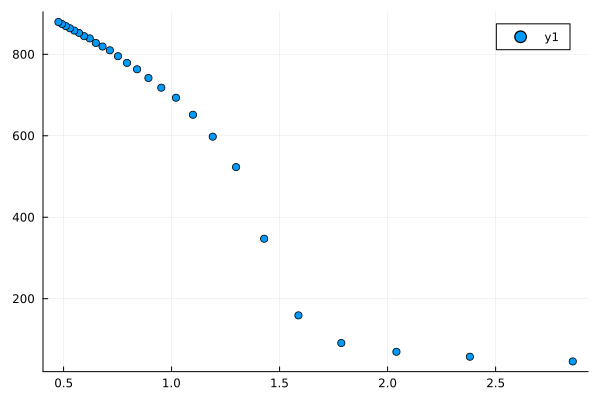

In [23]:
plot(T[5:30],Ms2[5:30],seriestype = :scatter) # M vs T

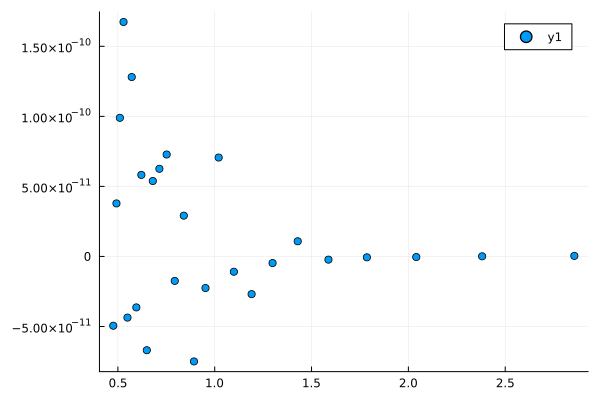

In [25]:
plot(T[5:30],Ss2[5:30],seriestype = :scatter) # M vs T